## Recurrent Neural Networks (RNN)

### GPU selection

Select the GPU id to use.

In [1]:
# Select the right device. Change the number to select a different GPU.
# If you have used slurm to request a GPU, just keep this line as it is.
device_id = 0

In [2]:
import torch
from torch import cuda
from multiprocessing import cpu_count

# Automatic device selection
if cuda.is_available():
    torch.set_num_threads(cpu_count() // cuda.device_count())
    device = torch.device(f"cuda:{device_id}")
else:
    torch.set_num_threads(cpu_count())
    device = torch.device("cpu")
device

device(type='cuda', index=0)

### Hyperparameters

These are the hyperparameters used throughout this chapter. Placed here for
easier experiments.

There are too many hyperparameters to save as plain variables, so let's group
them into one object: the `Params` class. Observe the differences between
saving them as a dictionary and as a class instance.

In [3]:
from typing import Type

from torch import nn, optim


class Params:
    def __init__(self,
                 batch_size: int = 128, epochs: int = 20, lr: float = 1e-4,
                 embedding_dim: int = 32, hidden_dim: int = 32,
                 num_layers: int = 3, dropout: float = 0.2,
                 RNN: Type[nn.Module] = nn.GRU,
                 readout: str = "max",
                 Optimizer: Type[optim.Optimizer] = optim.Adam,
                 print_every: int = 4):
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.RNN = RNN
        self.readout = readout
        self.Optimizer = Optimizer
        self.print_every = print_every


SEED = 42
params = Params()

### Data preprocessing

Now we're going to use a chemistry-oriented dataset: [tdc](https://tdcommons.ai).
It is a collection of datasets for drug discovery and is already preprocessed
for machine learning. Among them, the `hERG Central` dataset, a part of the
`Tox` prediction problem is selected for our task. The set is a collection of
molecular structures expressed in SMILES strings and their percent inhibition of
the hERG channel. The set is selected because it contains ~300,000 molecules,
which is a reasonable size for training a deep learning model.

Here, our goal is to predict whether the molecule *is a hERG blocker or not**,
i.e., solving a binary classification problem.

\* Whether IC50 of the molecule is less than 10 µM or not.

In [4]:
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list

label_list = retrieve_label_name_list("herg_central")
data = Tox(name='herg_central', label_name=label_list[2])
split = data.get_split()

Found local copy...
Loading...
Done!


What's in the dataset?

In [5]:
split

{'train':          Drug_ID                                               Drug  Y
 0       26665387        COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1  0
 1       26732361  COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...  0
 2       49735227  COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...  0
 3       22413685                            Fc1ccc(Oc2ncccn2)c(F)c1  0
 4       24783074     Cc1onc(C(=O)Nc2sc3c(c2C#N)CCCC3)c1[N+](=O)[O-]  0
 ...          ...                                                ... ..
 214820  49824526          COc1ccc(-c2c(-c3ccccc3OC)sc3ccccc23)cc1OC  0
 214821  22411411  COC(=O)c1c(NC(=O)CN2CCN(S(=O)(=O)c3ccccc3[N+](...  0
 214822   4247425  O=C(Cn1c(=O)n(Cc2ccco2)c(=O)c2cc(Cl)ccc21)NCC1...  0
 214823  26728232    CC(=O)CSc1nnc(CN2C(=O)CSc3ccc(C(F)(F)F)cc32)n1C  0
 214824  49718253  CCOC(=O)[C@@H]1[C@H]2COc3ccc(Br)cc3[C@H]2N2C(=...  0
 
 [214825 rows x 3 columns],
 'valid':         Drug_ID                                               Drug  Y
 0      85146795 

So the "split" is a dictionary of three keys, `train`, `valid`, and `test`.
The other two are already familiar with us, but here we have one more: the
`test` set. What is it actually?

Before getting to the answer directly, think about why we needed a validation
set. What does it validate? Well, the model, of course. More precisely, the set
validates the model's ability to generalize. The validation set *validates* the
model's parameters, that the model indeed performs well on the unseen data.
That's why the model is trained on the training set and evaluated on the
validation set.

Now think about the training procedure. We tune the hyperparameters of the model
to maximize the performance on the validation set. Did you get the point here?
We have a "test" set for the model parameters, the validation set, but we don't
have one for the *hyperparameters*. That's why we need the test set. We will
use it to evaluate the model's actual performance, with the best hyperparameters
(or at least, the best we can get).

Next, let's take a closer look at the training set. It is a standard
`pandas.DataFrame` object with three columns: PubChem CID of the drug, SMILES
string, and the label. The others are also `pandas.DataFrame` objects with the
same layout.

In [6]:
split["train"]

,Drug_ID,Drug,Y
0,26665387,COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1,0
1,26732361,COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...,0
2,49735227,COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...,0
3,22413685,Fc1ccc(Oc2ncccn2)c(F)c1,0
4,24783074,Cc1onc(C(=O)Nc2sc3c(c2C#N)CCCC3)c1[N+](=O)[O-],0
...,...,...,...
214820,49824526,COc1ccc(-c2c(-c3ccccc3OC)sc3ccccc23)cc1OC,0
214821,22411411,COC(=O)c1c(NC(=O)CN2CCN(S(=O)(=O)c3ccccc3[N+](...,0
214822,4247425,O=C(Cn1c(=O)n(Cc2ccco2)c(=O)c2cc(Cl)ccc21)NCC1...,0
214823,26728232,CC(=O)CSc1nnc(CN2C(=O)CSc3ccc(C(F)(F)F)cc32)n1C,0


As usual, we need to wrap those dataframes with a pytorch `Dataset` class. One
thing to note here is that we have to convert the SMILES strings to the standard
pytorch `Tensor`s before feeding them into the model. Let's do it here, so that
we don't have to convert every time retrieving a sample.

In [7]:
from collections import Counter

mapping = Counter(c for smiles in data.entity1 for c in smiles)
mapping.most_common()

[('c', 3379056),
 ('C', 2261877),
 ('(', 1259627),
 (')', 1259627),
 ('1', 891209),
 ('O', 877213),
 ('=', 650423),
 ('2', 636321),
 ('N', 531525),
 ('n', 352423),
 ('3', 257828),
 ('S', 123148),
 ('[', 103232),
 (']', 103232),
 ('-', 84076),
 ('F', 69489),
 ('l', 63085),
 ('/', 60403),
 ('H', 54053),
 ('o', 50749),
 ('4', 49028),
 ('s', 47252),
 ('@', 34905),
 ('+', 23122),
 ('B', 16051),
 ('r', 16032),
 ('#', 14263),
 ('.', 12118),
 ('\\', 11921),
 ('5', 4649),
 ('P', 1229),
 ('I', 565),
 ('6', 352),
 ('a', 178),
 ('7', 54),
 ('K', 48),
 ('A', 36),
 ('%', 18),
 ('8', 16),
 ('9', 10),
 ('0', 10),
 ('i', 8),
 ('g', 4),
 ('t', 3),
 ('e', 3),
 ('M', 2),
 ('L', 2),
 ('Z', 1),
 ('d', 1)]

Ok, not bad... But what are `l`, `r`, `a`, etc.? We don't have them in
chemistry!

The problem here is that each character in the SMILES string is **not** a
*token*. We need a more sophisticated tokenizing scheme than the simple for
loop. For the task, we need to take a look at the SMILES format specification*,
and then implement a tokenizer that can split a SMILES string into a list of
tokens.

\* See http://opensmiles.org/opensmiles.html

In [8]:
import re

# Q) Why do we need Cl and Br first?
token_re = re.compile(r"(\[[^\]]+\]|Cl|Br|[BCNOPSFIbcnops]|.)")
# Q) Why do we need separate rules for "[A-Z][a-z]*" and "[a-z]*"?
#    What would happen if we merge them together into "[A-Z]?[a-z]*"?
bracket_re = re.compile(r"(\d+|[A-Z][a-z]*|[a-z]+|.)")


def smi_to_tok(smiles: str):
    for tok in token_re.finditer(smiles):
        tok = tok.group()
        if tok.startswith("["):
            for t in bracket_re.finditer(tok):
                yield t.group()
        else:
            yield tok


mapping = Counter(tok for smiles in data.entity1 for tok in smi_to_tok(smiles))
mapping.most_common()

[('c', 3379056),
 ('C', 2198789),
 ('(', 1259627),
 (')', 1259627),
 ('1', 891208),
 ('O', 877213),
 ('=', 650423),
 ('2', 636321),
 ('N', 531349),
 ('n', 352422),
 ('3', 257828),
 ('S', 123141),
 ('[', 103232),
 (']', 103232),
 ('-', 84076),
 ('F', 69488),
 ('Cl', 63085),
 ('/', 60403),
 ('H', 54051),
 ('o', 50748),
 ('4', 49028),
 ('s', 47215),
 ('@', 34905),
 ('+', 23122),
 ('Br', 16032),
 ('#', 14263),
 ('.', 12118),
 ('\\', 11921),
 ('5', 4648),
 ('P', 1226),
 ('I', 565),
 ('6', 352),
 ('Na', 175),
 ('7', 54),
 ('K', 48),
 ('As', 36),
 ('B', 18),
 ('%', 18),
 ('8', 16),
 ('9', 10),
 ('0', 10),
 ('Si', 6),
 ('Pt', 3),
 ('Mg', 2),
 ('Li', 2),
 ('Hg', 2),
 ('Ca', 2),
 ('se', 1),
 ('Ba', 1),
 ('Zn', 1),
 ('Nd', 1),
 ('Co', 1),
 ('Fe', 1),
 ('15', 1),
 ('Se', 1)]

Great! Now we made all symbols "chemical," so the next step will be converting
them into indices.

In [9]:
# Q) Why do we start the index from 1?
tok_to_idx = {
    tok: idx for idx, (tok, _) in enumerate(mapping.most_common(), 1)}

Finally we have the dataset class for our model.

In [10]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader


class HergCentralDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        # Q) Why do we need a list of Tensors, not a 2D Tensor?
        self.smiles = [
            torch.tensor([tok_to_idx[tok] for tok in smi_to_tok(smiles)])
            for smiles in data["Drug"]]
        self.y = torch.tensor(data["Y"].values, dtype=torch.long)

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = self.smiles[idx]
        y = self.y[idx]
        return x, y

And the actual datasets for future use.

In [11]:
datasets = {k: HergCentralDataset(v) for k, v in split.items()}

### RNN model

A SMILES string is basically a list of tokens, so it is natural to use a
model that could handle sequences by design: the *RNN*s. RNNs, or Recurrent
Neural Networks, were proposed for tasks related to sequential data. The basic
idea is that the model has a *memory* that stores the information about the
previous inputs.

The memory is implemented as a hidden state, which is, in turn, a vector of
numbers. The hidden state is updated along the model's output at each time step
and used as a part of the input for the next time step.

#### Main model

So, this is our main model.

In [12]:
class RNN(nn.Module):
    def __init__(self, params: Params):
        super().__init__()
        self.params = params

        if self.params.num_layers < 1:
            raise ValueError("num_layers must be >= 1")

        # Embedding layer
        self.embedding = nn.Embedding(
            len(tok_to_idx) + 1, self.params.embedding_dim, padding_idx=0)

        # RNN layers
        self.middle = self.params.RNN(
            self.params.embedding_dim, self.params.hidden_dim,
            num_layers=self.params.num_layers,
            dropout=self.params.dropout)

        # All readout functions make (L, N, hidden_dim) -> (N, hidden_dim)
        if self.params.readout == "sum":
            def readout(x: torch.Tensor):
                return x.sum(dim=0)
        elif self.params.readout == "mean":
            def readout(x: torch.Tensor):
                return x.mean(dim=0)
        elif self.params.readout == "max":
            def readout(x: torch.Tensor):
                return x.max(dim=0)[0]
        elif self.params.readout == "last":
            def readout(x: torch.Tensor):
                return x[-1]
        else:
            raise ValueError(f"Unknown readout: {self.params.readout}")

        self.readout = readout

        # Linear projection to the output
        # Q) Why do we need 2 outputs?
        self.out = nn.Linear(self.params.hidden_dim, 2)

    def forward(self, X: torch.Tensor):
        # Shape: (L, N) -> (L, N, embedding_dim)
        h = self.embedding(X)
        # Shape: (L, N, embedding_dim) -> (L, N, hidden_dim)
        h, _ = self.middle(h)
        # Shape: (L, N, hidden_dim) -> (N, hidden_dim)
        h = self.readout(h)
        # Shape: (N, hidden_dim) -> (N, 2)
        y_hat = self.out(h)
        return y_hat

### Training and validation code

They are mostly imported from the previous chapter. Still, there are some
significant changes.

In [13]:
import numpy as np
from sklearn import metrics
from torch.nn import functional as F
from tqdm import tqdm, trange


class Callbacks:
    def __init__(self, model: nn.Module):
        self.model = model

    def on_epoch_begin(self):
        pass

    def on_batch_begin(self):
        pass

    def on_batch_end(self, loss: torch.Tensor):
        pass


class TrainingCallback(Callbacks):
    def __init__(self, model: nn.Module, optim: torch.optim.Optimizer):
        super().__init__(model)
        self.optim = optim

    def on_epoch_begin(self):
        self.model.train()

    def on_batch_begin(self):
        self.optim.zero_grad()

    def on_batch_end(self, loss: torch.Tensor):
        loss.backward()
        self.optim.step()


class ValidationCallback(Callbacks):
    def on_epoch_begin(self):
        self.model.eval()


def run(model: nn.Module, criterion: nn.Module,
        loader: DataLoader, callbacks: Callbacks):
    callbacks.on_epoch_begin()

    epoch_loss = []
    epoch_true = []
    epoch_pred = []

    for x, y in loader:
        callbacks.on_batch_begin()

        # Here, we move the tensors to a GPU one batch at a time (if available).
        # It is indeed slower than moving the entire dataset to the GPU at once,
        # but it's also much more memory efficient.
        # For larger models with larger datasets, this is a good trade-off.
        # We want good models that might take long time to train, not bad
        # models that train fast.
        x = x.to(device)
        y = y.to(device)

        # Shape: (L, N) -> (N, 2)
        y_hat = model(x)
        # calculate loss
        loss = criterion(y_hat, y)

        callbacks.on_batch_end(loss)
        epoch_loss.append(loss.item())

        epoch_true.append(y.cpu().numpy())
        epoch_pred.append(y_hat.argmax(dim=1).cpu().numpy())

    epoch_true = np.concatenate(epoch_true)
    epoch_pred = np.concatenate(epoch_pred)
    epoch_accu = metrics.accuracy_score(epoch_true, epoch_pred)

    return np.mean(epoch_loss), epoch_accu


def train(model: nn.Module, criterion: nn.Module,
          loader: DataLoader, optimizer: optim.Optimizer):
    callbacks = TrainingCallback(model, optimizer)
    return run(model, criterion, loader, callbacks)


@torch.no_grad()
def validate(model: nn.Module, criterion: nn.Module, loader: DataLoader):
    callbacks = ValidationCallback(model)
    return run(model, criterion, loader, callbacks)


def train_rnn(model: RNN, criterion: nn.Module, train_loader, valid_loader):
    optimizer = params.Optimizer(model.parameters(), lr=params.lr)
    stats = []

    for epoch in trange(1, params.epochs + 1):
        train_loss, train_accu = train(
            model, criterion, train_loader, optimizer)
        valid_loss, valid_accu = validate(model, criterion, valid_loader)

        if not epoch % params.print_every or epoch in (1, params.epochs):
            tqdm.write((f"{train_loss = :.4f}, {train_accu = :.2%}, "
                        f"{valid_loss = :.4f}, {valid_accu = :.2%}"))

        stats.append((epoch, train_loss, train_accu, valid_loss, valid_accu))

    stats = pd.DataFrame.from_records(stats, columns=[
        "epoch", "train_loss", "train_accu", "valid_loss", "valid_accu"])
    return stats

And here are some utility functions, also imported from the previous chapter:

In [14]:
import random

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid", palette="muted")


def seed_everything(seed=SEED):
    """Seed all the random number generators for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def to_dataloader(dataset: HergCentralDataset, shuffle: bool):
    return DataLoader(dataset, params.batch_size,
                      shuffle=shuffle,
                      generator=torch.Generator().manual_seed(SEED))


def get_dataloaders():
    return (to_dataloader(v, k == "train") for k, v in datasets.items())


def print_model_summary(model: nn.Module):
    param_cnt = sum(param.numel()
                    for param in model.parameters() if param.requires_grad)

    print(model)
    print(f"Model has {param_cnt:,} trainable parameters")


def plot_stats(stats: pd.DataFrame):
    stats_long = stats.melt(
        id_vars="epoch", var_name="type", value_name="stat")
    stats_long["run"] = [tp.split("_")[0] for tp in stats_long["type"]]
    stats_long["type"] = [tp.split("_")[1] for tp in stats_long["type"]]

    epochs = params.epochs
    fg = sns.relplot(x="epoch", y="stat", data=stats_long,
                     hue="run", col="type", marker="o", kind="line",
                     col_order=["loss", "accu"],
                     facet_kws={"sharey": False, "xlim": (1, epochs + 1)})
    for ax in fg.axes[0, 1:]:
        ax.set_ylim(0, 1)

    xticks = list(range(1, epochs + 1, params.print_every))
    if epochs != xticks[-1]:
        xticks.append(epochs)
    fg.set(xticks=xticks)
    plt.show()

### Model training and hyperparameter optimization: first try

Now we're ready to train the model. Let's try!

In [15]:
criterion = nn.CrossEntropyLoss()
train_loader, valid_loader, test_loader = get_dataloaders()


def main():
    seed_everything()

    model = RNN(params).to(device)
    # Visualize the model
    print_model_summary(model)

    stats = train_rnn(model, criterion, train_loader, valid_loader)
    plot_stats(stats)

    return model


model = main()

RNN(
  (embedding): Embedding(56, 32)
  (middle): GRU(32, 32, num_layers=3, dropout=0.2)
  (out): Linear(in_features=32, out_features=2, bias=True)
)
Model has 20,866 trainable parameters


  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [31] at entry 0 and [63] at entry 1

Something is definitely wrong here. Could you find out what?

### Introduction to real-world problems

#### Collate function

The problem here is that the sequences (SMILES strings) have different lengths.
The `DataLoader` class requires that all samples in a batch are of the same
length. In the previous chapters, all figures (happened to) had the same size,
so we didn't have to worry about it. But in real-world problems like this, the
inputs might have different lengths.

So we need to *pad* the shorter sequences with some special tokens. Here, we'll
use `0` as the padding index, which is the most common choice (now you get why
we started the token indices from `1`).

The `collate_fn` argument of the `DataLoader` class is responsible for stacking
all the batch samples into a single pytorch `Tensor`. The default implementation
simply assumes all the samples are of the same length and try to stack them. But
here, we need to pad them before stacking, so we need to implement one on our
own.

In [16]:
from typing import List, Tuple

from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor]]):
    # Q) What does this line do?
    x, y = zip(*batch)
    # Shape: N (L_i, ) sized tensors -> (max(L_i), N)
    x = pad_sequence(x)
    # Shape: N * (, ) -> (N, )
    y = torch.stack(y)
    return x, y

Also don't forget to re-define the `to_dataloader` function.

In [17]:
def to_dataloader(dataset: HergCentralDataset, shuffle: bool):
    return DataLoader(dataset, params.batch_size,
                      shuffle=shuffle, collate_fn=collate_fn,
                      generator=torch.Generator().manual_seed(SEED))

Are we done? No, not yet. Since we've padded the sequences, the model should
ignore the padding indices. However, the current model assumes every token is
valid, and that could lead to incorrect training.

Before actually fixing the model, first we need some utility functions.

In [18]:
def get_mask(X: torch.Tensor):
    return X != 0


def masked_sum(X: torch.Tensor, mask: torch.Tensor):
    return (X * mask).sum(dim=0)


def masked_mean(X: torch.Tensor, mask: torch.Tensor):
    x_sum = masked_sum(X, mask)
    mask_sum = mask.sum(dim=0)
    return x_sum / mask_sum


def masked_max(X: torch.Tensor, mask: torch.Tensor):
    return (X * mask).max(dim=0)[0]


def masked_last(X: torch.Tensor, mask: torch.Tensor):
    # Q) Why the following line works?
    last_idx = mask.sum(dim=0) - 1
    return X[last_idx, torch.arange(mask.shape[1], device=X.device)]

In [19]:
class RNN(nn.Module):
    def __init__(self, params: Params):
        super().__init__()
        self.params = params

        if self.params.num_layers < 1:
            raise ValueError("num_layers must be >= 1")

        # Embedding layer
        self.embedding = nn.Embedding(
            len(tok_to_idx) + 1, self.params.embedding_dim, padding_idx=0)

        # RNN layers
        self.middle = self.params.RNN(
            self.params.embedding_dim, self.params.hidden_dim,
            num_layers=self.params.num_layers,
            dropout=self.params.dropout)

        # All readout functions make (L, N, hidden_dim) -> (N, hidden_dim)
        if self.params.readout == "sum":
            self.readout = masked_sum
        elif self.params.readout == "mean":
            self.readout = masked_mean
        elif self.params.readout == "max":
            self.readout = masked_max
        elif self.params.readout == "last":
            self.readout = masked_last
        else:
            raise ValueError(f"Unknown readout: {self.params.readout}")

        # Linear projection to the output
        self.out = nn.Linear(self.params.hidden_dim, 2)

    def forward(self, X: torch.Tensor):
        # Q) Why do we unsqueeze the mask?
        mask = get_mask(X).unsqueeze_(-1)

        # Shape: (L, N) -> (L, N, embedding_dim)
        h = self.embedding(X)
        # Shape: (L, N, embedding_dim) -> (L, N, hidden_dim)
        h, _ = self.middle(h)
        # Shape: (L, N, hidden_dim) -> (N, hidden_dim)
        h = self.readout(h, mask)
        # Shape: (N, hidden_dim) -> (N, 2)
        y_hat = self.out(h)
        return y_hat

Now we can train the model.

RNN(
  (embedding): Embedding(56, 32, padding_idx=0)
  (middle): GRU(32, 32, num_layers=3, dropout=0.2)
  (out): Linear(in_features=32, out_features=2, bias=True)
)
Model has 20,866 trainable parameters


  5%|▌         | 1/20 [00:10<03:24, 10.74s/it]

train_loss = 0.2559, train_accu = 91.21%, valid_loss = 0.1788, valid_accu = 95.68%


 20%|██        | 4/20 [00:41<02:43, 10.21s/it]

train_loss = 0.1821, train_accu = 95.48%, valid_loss = 0.1744, valid_accu = 95.67%


 40%|████      | 8/20 [01:22<02:03, 10.30s/it]

train_loss = 0.1531, train_accu = 95.48%, valid_loss = 0.1490, valid_accu = 95.67%


 60%|██████    | 12/20 [02:01<01:19,  9.88s/it]

train_loss = 0.1481, train_accu = 95.48%, valid_loss = 0.1462, valid_accu = 95.67%


 80%|████████  | 16/20 [02:37<00:37,  9.34s/it]

train_loss = 0.1449, train_accu = 95.49%, valid_loss = 0.1436, valid_accu = 95.67%


100%|██████████| 20/20 [03:12<00:00,  9.62s/it]


train_loss = 0.1424, train_accu = 95.50%, valid_loss = 0.1405, valid_accu = 95.66%


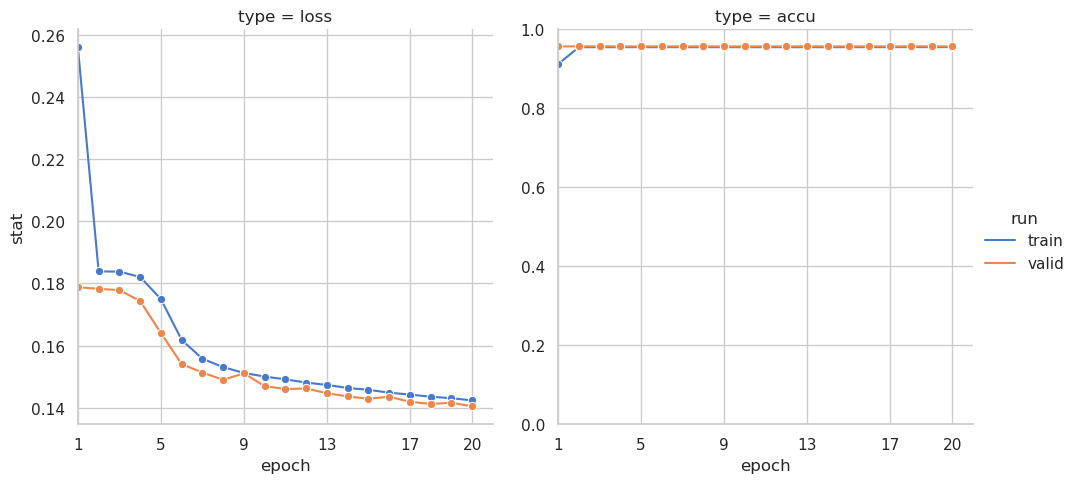

In [20]:
train_loader, valid_loader, test_loader = get_dataloaders()
model = main()

#### Imbalanced dataset

It seems that the model performs really well, but is it *really* good? Let's
take a deeper look into the dataset.

In [21]:
datasets["train"].y.float().mean().item()

0.04515303298830986

The mean of the labels is around 0.05, which means the dataset is *imbalanced*.
In such case, if a model predicts all samples as "not a hERG blocker," it would
still get a 95% accuracy. Indeed, it is happening here: let's draw a confusion
matrix of the trained model on the validation set.

(0.04324024894913487, 0.0005213594447521913)

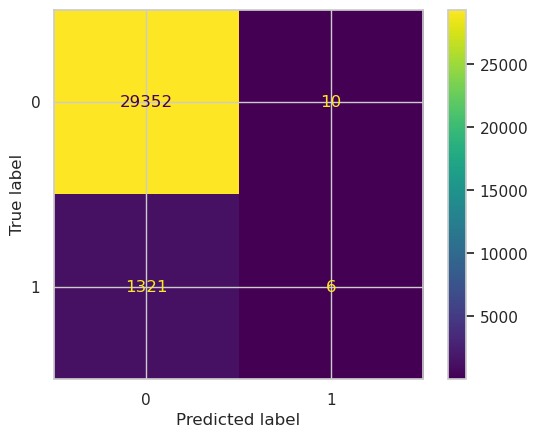

In [22]:
@torch.no_grad()
def draw_confusion_matrix():
    model.eval()

    y_true = []
    y_pred = []
    for X, y in valid_loader:
        y_true.append(y.numpy())

        y_hat = model(X.to(device))
        y_pred.append(y_hat.argmax(dim=1).cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    return y_true, y_pred


y_true, y_pred = draw_confusion_matrix()
y_true.mean(), y_pred.mean()

The model merely predicts everything (>99.9%) to be "not a hERG blocker." This
is not what we're happy with. An important implication from this result is that
you should never blindly trust the numbers that models produce. Always take a
look at the details.

Well, actually, there *is* another metric that is much more useful than the
accuracy for this case: the F1 score. It is defined as a harmonic mean of the
precision and recall, and it is more robust to the imbalanced dataset (still,
this does not invalidate the claim that we've made in the last paragraph).

The model now performs terribly in terms of the F1 score.

In [23]:
metrics.f1_score(y_true, y_pred)

0.008935219657483246

There are many ways to deal with the imbalanced dataset problem. One of the
easiest ways is to adjust weights of the loss function, so that the model could
take account the imbalance. The weights are calculated as the inverse of the
class frequencies.

Note that we need to have the sum of the weight equal to the count of the
classes, so that the loss does not (accidentally) scale down the learning rate.

In [24]:
train_set = datasets["train"]

total = len(train_set)
pos_freq = train_set.y.sum().item() / total

w = torch.tensor([pos_freq, 1 - pos_freq])
w *= len(w)

criterion = nn.CrossEntropyLoss(weight=w).to(device)

### Model training and hyperparameter optimization: second try

Let's see the differences.

RNN(
  (embedding): Embedding(56, 32, padding_idx=0)
  (middle): GRU(32, 32, num_layers=3, dropout=0.2)
  (out): Linear(in_features=32, out_features=2, bias=True)
)
Model has 20,866 trainable parameters


  5%|▌         | 1/20 [00:08<02:45,  8.71s/it]

train_loss = 0.6418, train_accu = 66.39%, valid_loss = 0.5840, valid_accu = 68.20%


 20%|██        | 4/20 [00:38<02:31,  9.48s/it]

train_loss = 0.5245, train_accu = 77.13%, valid_loss = 0.5253, valid_accu = 74.65%


 40%|████      | 8/20 [01:15<01:53,  9.46s/it]

train_loss = 0.4999, train_accu = 78.22%, valid_loss = 0.5056, valid_accu = 81.49%


 60%|██████    | 12/20 [01:56<01:20, 10.02s/it]

train_loss = 0.4861, train_accu = 78.59%, valid_loss = 0.4955, valid_accu = 81.79%


 80%|████████  | 16/20 [02:35<00:39,  9.83s/it]

train_loss = 0.4757, train_accu = 79.06%, valid_loss = 0.4875, valid_accu = 81.80%


100%|██████████| 20/20 [03:15<00:00,  9.78s/it]


train_loss = 0.4705, train_accu = 79.56%, valid_loss = 0.4799, valid_accu = 79.51%


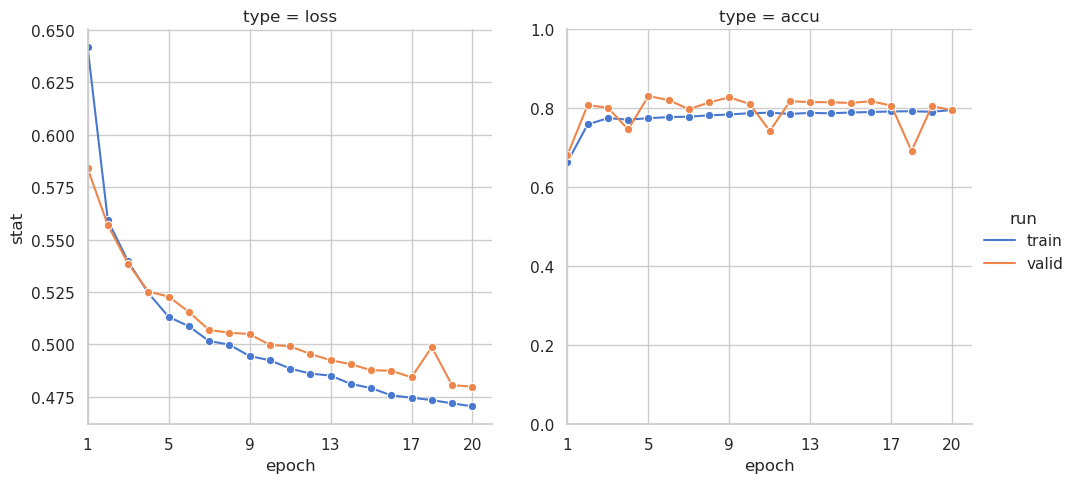

In [25]:
train_loader, valid_loader, test_loader = get_dataloaders()
model = main()

Yes, the model seems to be performing worse than the previous one in terms of
accuracy, but the more important thing here is that the model has now started to
consider the "hERG blocker" class. Check out the **much** better F1 score.

Also, the training loss seems not to be saturated, so this model *might* perform
better than the previous one eventually.

(0.22793183225259864, 0.04324024894913487, 0.24441240086517665)

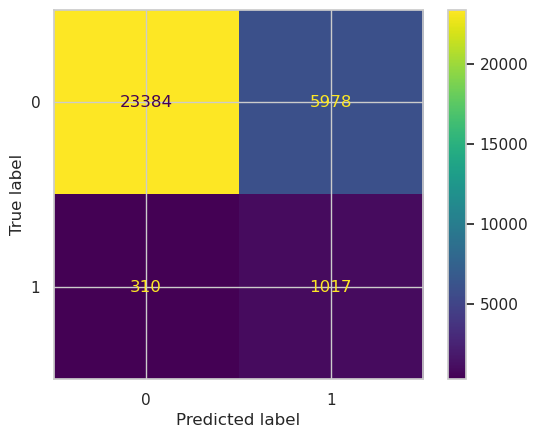

In [26]:
y_true, y_pred = draw_confusion_matrix()
y_pred.mean(), y_true.mean(), metrics.f1_score(y_true, y_pred)

### Model training and hyperparameter optimization: last try

How do we make the model good in both metrics: accuracy and the F1 score? Well,
good luck, and it's your turn. This lecture is intended to demonstrate the RNN
model with a good quality code, not to provide a complete solution to this
problem. So, you need to figure out how to fix the model yourself.

Adjusting the hyperparameters at the beginning of this notebook might help.
Or you may need to change the model architecture, training procedure, etc. This
is the essence of deep learning research: **YOU figure out how to make the model
work**.

### Model evaluation

Once satisfied with the model, you can evaluate the final model on the test set.
This is your *score* on this problem. Never be tempted to evaluate the model on
the test set beforehand: it's cheating.

In [27]:
validate(model, criterion, test_loader)

(0.4715857890745004, 0.7991332540445429)

### Summary

We have learned about a real-world cheminformatics problem in this chapter.
Specifically, we:

- Learned about the SMILES format and how to tokenize it.
- Could now handle datasets with heterogeneous lengths.
- Discussed the imbalanced dataset problem.

And most importantly, we have a lesson: **never blindly trust the "accuracy" or
any other metrics**. Do you really want a model that considers everything,
*literally everything*, safe as a drug?